目前我们学习过的所有神经网络的一个共同特点就是它们都没有记忆，包括全连接网络和卷积网络。每一个输入给它们的数据都是独立进行处理的，在这些输入数据之间不存在这任何状态。要在这样的网络上处理一个序列或者时间序列数据，你就不得不一次性的将整个序列输入给网络，也就是说将序列转换成单个的数据点。正如我们在IMDB例子中做的那样：一整个电影评论被转换称为一个大的向量，然后在一次过程中整个被网络进行处理。这样的网络被称为“**前馈网络**”。

相对的，你在阅读这段文字的时候，是一个单词一个单词的进行处理的，或者更确切的说，是眼睛依次扫视下去的，同时你的大脑保留了前面扫视过的内容的记忆，也就是说你阅读本段文字时有着流动的表现形式。生物智慧在处理信息是是渐进式的，会保留一个内在的模型用来处理这些信息，当前模型的状态是由过去的信息决定的，并且能够持续的根据新的信息来进行更新。

**循环神经网络（RNN）**采用了同样的原理，尽管只是一个极端简化后的版本：它们使用迭代式的方法处理序列中的元素并且使用一个内部的状态保存过程中已经处理的信息。效果上，RNN是神经网络的一种类型，它有一个内部的循环（图6-8）。这里的状态会在处理两个不同的独立的序列之间进行重置（例如两个不同的IMDB评论），因此我们仍然可以将一个序列考虑为一个单独的数据点，也就是网络的一个单独的数据，这里不同的只是这个数据点不再是一次处理完，而是网络内部会循环处理序列中的元素。

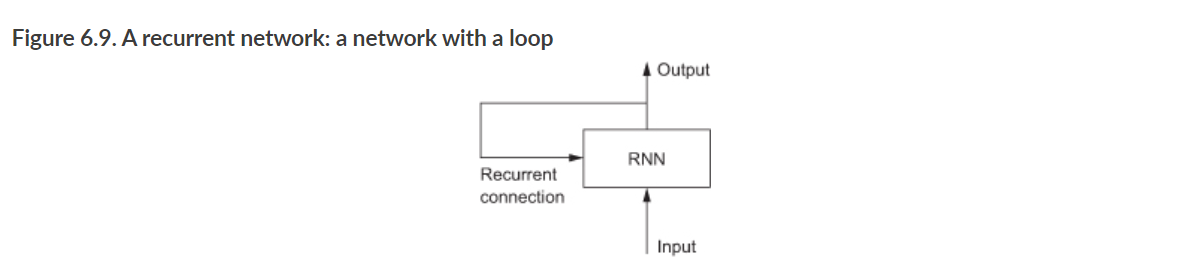
                                  图6-9 循环神经网络

为了更加清晰的阐述循环的概念，我们在Numpy中实现一个示例RNN的前向过程。这个RNN接受一个向量序列作为输入，我们会将它编码成一个形状为(timestep, features)的二维张量。这个网络在时间步长上进行循环，在每个时间步长上，都会根据t时刻的内部状态和t时刻的输入值（形状为(input_features, )的向量），结合一起计算得到t时刻的输出值。然后我们简单将下一步的状态值设置上次的输出值。在第一步时，“上一次输出”是未定义的，因此这时没有“当前状态”，我们可以将这时的状态初始化为全零的向量，称为网络的“**初始化的状态**”。

我们用下面的伪代码实现这个RNN：

In [ ]:
#RNN伪代码
state_t = 0

for input_t in input_sequences:
    output_t = f(input_t, state_t)
    state_t = output_t
    
    
#更详细的RNN伪代码
state_t = 0

for input_t in input_sequences:
    output_t = activatoin(dot(W, input_t) + dot(U, state_t) + b)
    state_t = output_t

In [ ]:
#简单RNN得numpy实现
import 

## 6.2.1 Keras中的循环层

**只使用循环神经网络中的最后一个状态**

In [1]:
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, SimpleRNN, LSTM
from keras.preprocessing.sequence import pad_sequences

max_word = 10000    #最常见的10000词
embedding_dim = 32  #shape(x) = 32
state_dim = 32      #shape(h) = 32
max_len = 100       #截取前100个词

#1、从Keras中加载数据集
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=max_word)

#2、将数据进行填充以便输入到Embedding层中
print(len(train_data), len(test_data))
train_data = pad_sequences(train_data, maxlen=max_len)
test_data = pad_sequences(test_data, maxlen=max_len)

#show train_data's and test_data's shape
print(train_data.shape, test_data.shape)

#3、构建RNN
network = Sequential()
network.add(Embedding(max_word, embedding_dim, input_length = max_len))
network.add(SimpleRNN(state_dim, return_sequences=False))
network.add(Dense(1, activation='sigmoid'))
network.summary()

#4、划分训练集和验证集
x_train = train_data[:15000]
y_train = train_labels[:15000]

x_val = train_data[15000:]
y_val = train_labels[15000:]

#5、编译网络
network.compile('rmsprop', 'binary_crossentropy', 'accuracy')

#6、拟合模型
history = network.fit(x_train, y_train, epochs = 10, batch_size=128, validation_data=(x_val, y_val))

25000 25000
(25000, 100) (25000, 100)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 32)           320000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                2080      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 322,113
Trainable params: 322,113
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
118/118 [==============================] - 3s 16ms/step - loss: 0.6099 - accuracy: 0.6573 - val_loss: 0.4722 - val_accuracy: 0.7950
Epoch 2/10
118/118 [==============================] - 2s 15ms/step - loss: 0.3863 - accuracy: 0.8404 - val_loss: 0.5090 - val_accurac

**绘制结果**

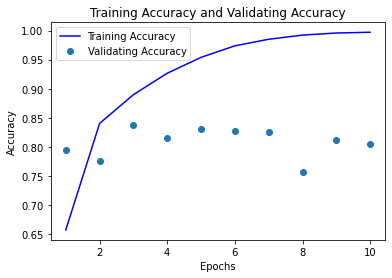

In [2]:
#1、训练精度和验证精度
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label = "Training Accuracy")
plt.plot(epochs, val_acc, 'o', label = "Validating Accuracy")
plt.title("Training Accuracy and Validating Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

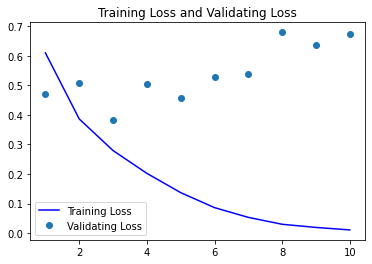

In [3]:
#2、训练损失和验证损失
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, 'b', label = "Training Loss")
plt.plot(epochs, val_loss, 'o', label = "Validating Loss")
plt.title("Training Loss and Validating Loss")
plt.legend()

plt.show()

In [4]:
test_loss, test_acc = network.evaluate(test_data, test_labels)
print(test_loss, test_acc)

782/782 [==============================] - 2s 2ms/step - loss: 0.6910 - accuracy: 0.7988
0.6910144686698914 0.798799991607666


使用循环神经网络中的所有状态

In [5]:
network = Sequential()
network.add(Embedding(max_word, embedding_dim, input_length = max_len))
network.add(SimpleRNN(state_dim, return_sequences=True))
network.add(Flatten())
network.add(Dense(1, activation='sigmoid'))

network.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 32)           320000    
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 100, 32)           2080      
                                                                 
 flatten (Flatten)           (None, 3200)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 3201      
                                                                 
Total params: 325,281
Trainable params: 325,281
Non-trainable params: 0
_________________________________________________________________


In [6]:
#编译网络
network.compile('rmsprop', 'binary_crossentropy', 'accuracy')

#拟合模型
history = network.fit(x_train, y_train, epochs = 10, batch_size=128, validation_data=(x_val, y_val))

Epoch 1/10
118/118 [==============================] - 3s 17ms/step - loss: 0.5921 - accuracy: 0.6635 - val_loss: 0.5277 - val_accuracy: 0.7310
Epoch 2/10
118/118 [==============================] - 2s 16ms/step - loss: 0.3325 - accuracy: 0.8606 - val_loss: 0.3857 - val_accuracy: 0.8185
Epoch 3/10
118/118 [==============================] - 2s 16ms/step - loss: 0.1959 - accuracy: 0.9245 - val_loss: 0.4002 - val_accuracy: 0.8216
Epoch 4/10
118/118 [==============================] - 2s 17ms/step - loss: 0.0893 - accuracy: 0.9707 - val_loss: 0.5426 - val_accuracy: 0.8272
Epoch 5/10
118/118 [==============================] - 2s 16ms/step - loss: 0.0296 - accuracy: 0.9917 - val_loss: 0.6212 - val_accuracy: 0.8102
Epoch 6/10
118/118 [==============================] - 2s 17ms/step - loss: 0.0092 - accuracy: 0.9975 - val_loss: 0.7646 - val_accuracy: 0.8050
Epoch 7/10
118/118 [==============================] - 2s 21ms/step - loss: 0.0052 - accuracy: 0.9988 - val_loss: 0.7629 - val_accuracy: 0.7794

**绘制结果**

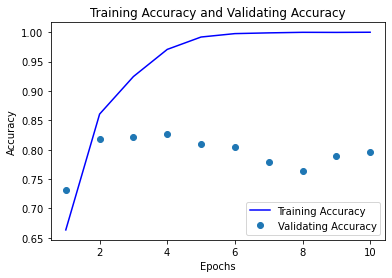

In [7]:
#1、训练精度和验证精度
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label = "Training Accuracy")
plt.plot(epochs, val_acc, 'o', label = "Validating Accuracy")
plt.title("Training Accuracy and Validating Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

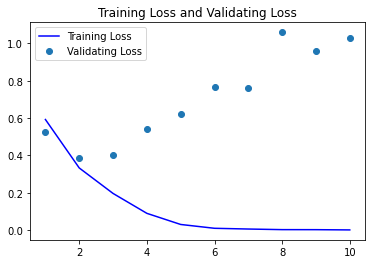

In [8]:
#2、训练损失和验证损失
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, 'b', label = "Training Loss")
plt.plot(epochs, val_loss, 'o', label = "Validating Loss")
plt.title("Training Loss and Validating Loss")
plt.legend()

plt.show()

In [9]:
test_loss, test_acc = network.evaluate(test_data, test_labels)
print(test_loss, test_acc)

782/782 [==============================] - 2s 3ms/step - loss: 1.0505 - accuracy: 0.7937
1.050528645515442 0.793720006942749


In [10]:
print("Training Accuracy", max(acc))
print("Validating Accuracy", max(val_acc))
print("Test Accuracy", test_acc)

Training Accuracy 0.9998666644096375
Validating Accuracy 0.8271999955177307
Test Accuracy 0.793720006942749


### 6.2.2 理解LSTM层和GRU层

In [11]:
from keras.layers import LSTM

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 32)          320000    
                                                                 
 lstm (LSTM)                 (None, 32)                8320      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 328,353
Trainable params: 328,353
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
118/118 [==============================] - 7s 49ms/step - loss: 0.5447 - accuracy: 0.7297 - val_loss: 0.4202 - val_accuracy: 0.8272
Epoch 2/10
118/118 [==============================] - 5s 41ms/step - loss: 0.3338 - accuracy: 0.8663 - val_loss: 0.6553 - val_accuracy: 0.7511
Epoch 3/10
118/118 [======

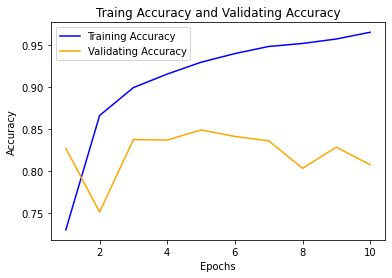

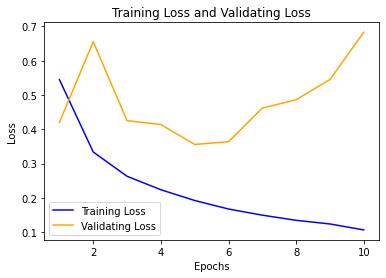

In [12]:
network = Sequential()
network.add(Embedding(max_word, embedding_dim))
network.add(LSTM(state_dim, return_sequences=False))   #只使用最后一个状态ht输入到分类器中
network.add(Dense(1, activation='sigmoid'))

#编译网络
network.compile('rmsprop', 'binary_crossentropy', 'accuracy')
network.summary()

#拟合模型
history = network.fit(x_train, y_train, epochs = 10, batch_size=128, validation_data=(x_val, y_val))

#绘制训练精度和验证精度
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'blue', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'orange', label = 'Validating Accuracy')
plt.title('Traing Accuracy and Validating Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#绘制训练损失和验证损失
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'b' ,label = "Training Loss")
plt.plot(epochs, val_loss, 'orange', label =  "Validating Loss")
plt.title("Training Loss and Validating Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [13]:
test_loss, test_acc = network.evaluate(test_data, test_labels)
print(test_loss, test_acc)

782/782 [==============================] - 5s 6ms/step - loss: 0.7349 - accuracy: 0.7939
0.7349254488945007 0.7938799858093262


In [14]:
print("Training Accuracy", max(acc))
print("Validating Accuracy", max(val_acc))
print("Test Accuracy", test_acc)

Training Accuracy 0.9657333493232727
Validating Accuracy 0.8490999937057495
Test Accuracy 0.7938799858093262


使用simple RNN在验证集和测试集上的精度为81.8%、78.5%
使用LSTM在验证集和测试集上的精度为85.1%、81.1%
可以看到LSTM的表现要比simple RNN好